In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-30T17:25:58.277736+08:00

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.4.0-200-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 72
Architecture: 64bit



#### 导入相关包

In [3]:
import os
import time
import numpy as np
import pandas as pd
import random
import torch
import torch.onnx
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import torchvision
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

import onnx
from onnxconverter_common.data_types import FloatTensorType
from onnxmltools import convert_sparkml
import onnxruntime  

import matplotlib.pyplot as plt
%matplotlib inline

#### 环境配置与参数设置

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
num_works = 5
batch_size = 256
epochs = 40
lr = 1e-4
num_class = 10

#### 加载数据与数据预处理

In [5]:
train_transforms = transforms.Compose([transforms.Resize((70, 70)), transforms.RandomCrop((64, 64)), transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((70, 70)), transforms.CenterCrop((64, 64)), transforms.ToTensor()])

In [6]:
# 提取 5test_dataloader0k的数据，48k 用于训练与验证、2k 用于测试
train_index = torch.arange(0, 45000)
val_index = torch.arange(45000, 50000)

In [7]:
train_val_dataset = datasets.CIFAR10(root=r"../data/cifar10", train = True, download = True, transform = train_transforms)
train_dataset = Subset(train_val_dataset, train_index)
val_dataset = Subset(train_val_dataset, val_index)
test_dataset = datasets.CIFAR10(root=r"../data/cifar10", train = False, download = False, transform = test_transforms)

Files already downloaded and verified


In [8]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, num_workers = num_works, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, num_workers = num_works, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, num_workers = num_works, shuffle= False)

In [9]:
classes_dict = dict(zip(range(0,10), ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])) 

In [10]:
train_image_sample, train_label_sample = next(iter(train_dataloader))
val_image_sample, val_label_sample = next(iter(val_dataloader))
test_image_sample, test_label_sample = next(iter(test_dataloader))

In [11]:
print("Train Set: image batch size= {}, \t label batch size= {}".format(train_image_sample.size(), train_label_sample.size()))
print("Val   Set: image batch size= {}, \t label batch size= {}".format(val_image_sample.size(), val_label_sample.size()))
print("Test  Set: image batch size= {}, \t label batch size= {}".format(test_image_sample.size(), test_label_sample.size()))

Train Set: image batch size= torch.Size([256, 3, 64, 64]), 	 label batch size= torch.Size([256])
Val   Set: image batch size= torch.Size([256, 3, 64, 64]), 	 label batch size= torch.Size([256])
Test  Set: image batch size= torch.Size([256, 3, 64, 64]), 	 label batch size= torch.Size([256])


In [12]:
def img_show(img):
    # img = img/2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

GroundTruth: 
   cat  ship  ship airplane


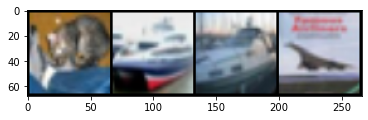

In [13]:
img_show(torchvision.utils.make_grid(test_image_sample[:4]))

print('GroundTruth: \n', ' '.join('%5s' % classes_dict[test_label_sample[j].numpy().take(0)] for j in range(4)))

#### 模型网络配置

In [14]:
class AlexNet(nn.Module):
    """
    input: 3*64*64
    cv2d: kernel_size = 11*11 64  stride = 4, padding = 2 # 3*64*64  -> 64*15*15 floor((64-11 + 2*2 + 4)/4)]
    relu: 
    max_pooling: kernel_size = 3*3, stride = 2            # 64*15*15 -> 64*7*7   floor((15-3+2)/2)
    cv2d: kernel_size = 5*5 192, stride = 1, padding = 2  # 64*7*7   -> 192*7*7  floor((7-5 + 2*2 + 1)/1)
    relu: 
    max_pooling: kernel_size = 3*3, stride = 2            # 192*7*7  -> 192*3*3  floor((7-3 + 2)/2)
    cv2d: kernel_size = 3*3 384, padding = 1              # 192*3*3  -> 384*3*3  floor((3-3+1*2 + 1)/1)
    relu:
    cv2d: kernel_size = 3*3 256, padding = 1              # 384*3*3  -> 256*3*3  floor((3-3+1*2 + 1)/1)
    relu:
    cv2d: kernel_size = 3*3 256, padding = 1              # 256*3*3  -> 256*3*3  floor((3-3+1*2 + 1)/1)
    relu:
    max_pooling: kernel_size = 3*3, stride = 2            # 256*3*3  -> 256*1*1  floor((3-3+2)/2)
    
    # avg pooling
    # fc
    dropout:
    line:
    relu:
    dropout:
    line:
    relu:
    line
    """
    def __init__(self):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 11, stride = 4, padding = 2), 
                                     nn.ReLU(inplace=True), 
                                     nn.MaxPool2d(kernel_size = 3, stride = 2), 
                                     nn.Conv2d(64, 192, kernel_size = 5, stride = 1, padding = 2), 
                                     nn.ReLU(inplace=True), 
                                     nn.MaxPool2d(kernel_size = 3, stride = 2), 
                                     nn.Conv2d(192, 384, kernel_size = 3, padding = 1), 
                                     nn.ReLU(inplace=True), 
                                     nn.Conv2d(384, 256, kernel_size = 3, padding = 1), 
                                     nn.ReLU(inplace=True), 
                                     nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
                                     nn.ReLU(inplace=True), 
                                     nn.MaxPool2d(kernel_size = 3, stride = 2)
                                    )
        self.avg_pool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(nn.Dropout(0.5), 
                                          nn.Linear(256*6*6, 4096), 
                                          nn.ReLU(inplace=True), 
                                          nn.Dropout(0.5), 
                                          nn.Linear(4096, 4096), 
                                          nn.ReLU(inplace=True), 
                                          nn.Linear(4096, num_class))
    def forward(self, x):
        x = self.feature(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), 256*6*6)
        x = self.classifier(x)
        x_prob = F.softmax(x, dim=1)
        return x, x_prob

#### 损失函数

In [15]:
criterion = nn.CrossEntropyLoss()

#### 优化器设置

In [16]:
torch.manual_seed(1)
model = AlexNet()
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

#### 训练模型

In [17]:
def train(epoch):
    model.train()
    train_loss = 0
    # true_list = list()
    # predict_list = list()
    for data, label in train_dataloader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        logits, probas = model(data)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()
        cost_list.extend([loss.item()])
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_dataloader.dataset)
    # true_labeles, predict_labeles = np.concatenate(true_list), np.concatenate(predict_list)
    # acc = np.sum(true_labeles == predict_labeles)/len(predict_labeles)
    # train_acc_list.append(acc)
    print("Epoch : {} \t Train Loss: {:.6f}".format(epoch, train_loss))

#### 验证评估模型

In [18]:
def val(epoch):
    model.eval()
    val_loss = 0
    true_list = list()
    predict_list = list()
    for data, label in test_dataloader:
        data, label = data.to(device), label.to(device)
        with torch.no_grad():
            logits, probas = model(data)
            _, predicted_labels = torch.max(probas, 1)
            # print(torch.max(probas, 1))
            # label_hat = torch.argmax(logits, 1)
            true_list.extend([label.cpu().data.numpy()])
            predict_list.extend([predicted_labels.cpu().data.numpy()])
            loss = criterion(logits, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_dataloader.dataset)
    true_labeles, predict_labeles = np.concatenate(true_list), np.concatenate(predict_list)
    acc = np.sum(true_labeles == predict_labeles)/len(predict_labeles)
    valid_acc_list.append(acc)
    print("Epoch : {} \t Validation Loss: {:.6f} \t Accuracy : {:.6f}".format(epoch, val_loss, acc))

In [19]:
start_time = time.time()
cost_list = list()
train_acc_list = list()
valid_acc_list = list()
for i in range(epochs):
    train(i)
    val(i)
    elapsed_time = (time.time() - start_time)/60
    print(f'Time Elapsed: {elapsed_time:.2f} min')
elapsed_time = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed_time:.2f} min')

Epoch : 0 	 Train Loss: 1.956625
Epoch : 0 	 Validation Loss: 1.683969 	 Accuracy : 0.349900
Time Elapsed: 0.29 min
Epoch : 1 	 Train Loss: 1.612120
Epoch : 1 	 Validation Loss: 1.526409 	 Accuracy : 0.420200
Time Elapsed: 0.58 min
Epoch : 2 	 Train Loss: 1.417670
Epoch : 2 	 Validation Loss: 1.433738 	 Accuracy : 0.470300
Time Elapsed: 0.87 min
Epoch : 3 	 Train Loss: 1.275409
Epoch : 3 	 Validation Loss: 1.186683 	 Accuracy : 0.567500
Time Elapsed: 1.16 min
Epoch : 4 	 Train Loss: 1.192282
Epoch : 4 	 Validation Loss: 1.147582 	 Accuracy : 0.587500
Time Elapsed: 1.45 min
Epoch : 5 	 Train Loss: 1.114032
Epoch : 5 	 Validation Loss: 1.099266 	 Accuracy : 0.603700
Time Elapsed: 1.74 min
Epoch : 6 	 Train Loss: 1.032335
Epoch : 6 	 Validation Loss: 1.042271 	 Accuracy : 0.625000
Time Elapsed: 2.03 min
Epoch : 7 	 Train Loss: 0.975304
Epoch : 7 	 Validation Loss: 0.984191 	 Accuracy : 0.646300
Time Elapsed: 2.32 min
Epoch : 8 	 Train Loss: 0.921533
Epoch : 8 	 Validation Loss: 0.962249 	

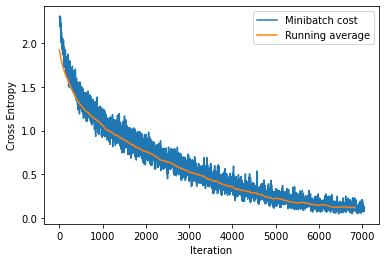

In [20]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

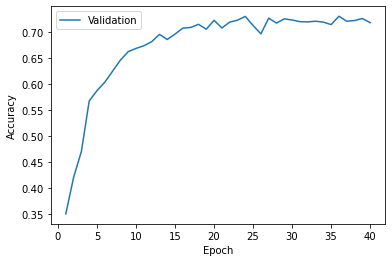

In [21]:
plt.plot(np.arange(1, epochs+1), valid_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 保存模型

In [22]:
torch.save(model.state_dict(), r"./model/cifar10_alexnet.pth")

In [23]:
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

#### 预测

In [24]:
def inference(dataloader_test, pth_model_path):
    model = AlexNet().to(device)
    model.load_state_dict(torch.load(pth_model_path))
    model.eval()
    predict_label_list = list()
    test_feature_list = list()
    for batch, data in enumerate(dataloader_test):
        x = data[0]
        x  = x.to(device)
        logits, probas = model(x)
        _, predicted_labels = torch.max(probas, 1)
        test_feature_list.append(x)
        predict_label_list.extend(predicted_labels.cpu().detach().numpy())
    test_feature = torch.cat(test_feature_list)
    return test_feature, predict_label_list

In [25]:
test_feature, predict_labels = inference(test_dataloader, pth_model_path=r"./model/cifar10_alexnet.pth")

预测结果为：truck


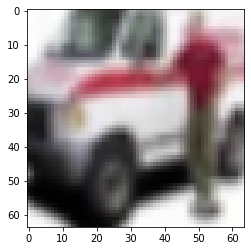

In [26]:
test_index = random.randint(0, len(predict_labels))
img_show(torchvision.utils.make_grid(test_feature[test_index].cpu()))
print('预测结果为：{}'.format(classes_dict[predict_labels[test_index]]))